## Example (not directly related to optimization code)
#### gurobi.Multidict
```python
names, lower, upper = multidict({ ’x’: [0, 1], ’y’: [1, 2], ’z’: [0, 3] })
print(names)
[’x’, ’y’, ’z’]
print(lower)
{’x’: 0, ’y’: 1, ’z’: 0}
print(upper)
{’x’: 1, ’y’: 2, ’z’: 3}
```

#### Pandas MultiIndex from product
```python
A = (1,2,3)
K = (1,2)
pd.MultiIndex.from_product((A,A,K), names=("i", "j", "k"))
```

In [1]:
import sys
sys.dont_write_bytecode = True

import numpy as np
import pandas as pd
import graphviz
import gurobipy as gp
from gurobipy import GRB
sys.path.append("simulator")
from simulator import simulator as sim
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
import matplotlib.pyplot as plt


random.seed(1234)

In [5]:
sim.three_depth_application()

User capacity: 99999999
A capacity: 33.333333333333336
B capacity: 100.0
C capacity: 40.0
D capacity: 25.0
E capacity: 33.333333333333336
F capacity: 100.0
- num_replica_for_cluster_0
	- User: 1
	- A: 2
	- B: 2
	- C: 2
	- D: 2
	- E: 2
	- F: 2
- num_replica_for_cluster_1
	- User: 1
	- A: 2
	- B: 2
	- C: 2
	- D: 2
	- E: 2
	- F: 2
===== print_service_and_replica =====
User
	cluster 0 User_0(node[0000])
	cluster 1 User_1(node[1000])
A
	cluster 0 A_0(node[0000])
	cluster 0 A_2(node[0000])
	cluster 1 A_1(node[1000])
	cluster 1 A_3(node[1000])
B
	cluster 0 B_0(node[0000])
	cluster 0 B_2(node[0000])
	cluster 1 B_1(node[1000])
	cluster 1 B_3(node[1000])
C
	cluster 0 C_0(node[0000])
	cluster 0 C_2(node[0000])
	cluster 1 C_1(node[1000])
	cluster 1 C_3(node[1000])
D
	cluster 0 D_0(node[0000])
	cluster 0 D_2(node[0000])
	cluster 1 D_1(node[1000])
	cluster 1 D_3(node[1000])
E
	cluster 0 E_0(node[0000])
	cluster 0 E_2(node[0000])
	cluster 1 E_1(node[1000])
	cluster 1 E_3(node[1000])
F
	cluster 0 F_0(

(<simulator.simulator.Replica at 0x7f99099846d0>,
 <simulator.simulator.Service at 0x7f9909984d90>)

## Predict the Service times


,service_name,rps,cpu,service_time
0,User,0,0.0,1325.017112
1,User,1,0.5,1841.934029
2,User,2,1.0,1845.138253
3,User,3,1.5,1788.879948
4,User,4,2.0,133.730352
...,...,...,...,...
695,F,95,47.5,9562.398124
696,F,96,48.0,11210.359871
697,F,97,48.5,11289.163197
698,F,98,49.0,11304.514313


Coefficients of linear regression model:  [ 2.37989926e-12  5.13486119e+01 -4.16325545e-01  5.61211064e+00
 -2.31526724e+01 -1.30928858e+02 -1.93669749e+01  1.16904109e+02
 -1.49525328e+00 -7.47626638e-01  5.13486119e+01 -7.10542736e-15
 -1.42108547e-14  5.68434189e-14 -7.10542736e-15  0.00000000e+00
  0.00000000e+00 -6.28644609e-01 -3.14322305e-01 -4.16325545e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.36595027e+00 -6.82975136e-01  5.61211064e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.29526180e-01 -3.64763090e-01 -2.31526724e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.45943017e+00  7.29715086e-01
 -1.30928858e+02  0.00000000e+00  0.00000000e+00  3.08136821e+00
  1.54068410e+00 -1.93669749e+01  0.00000000e+00  1.57884516e+00
  7.89422581e-01  1.16904109e+02 -4.89077576e+00 -2.44538788e+00
  7.80866955e-01  3.90433478e-01  1.95216739e-01]
The R^2 value in the test set is 0.95803


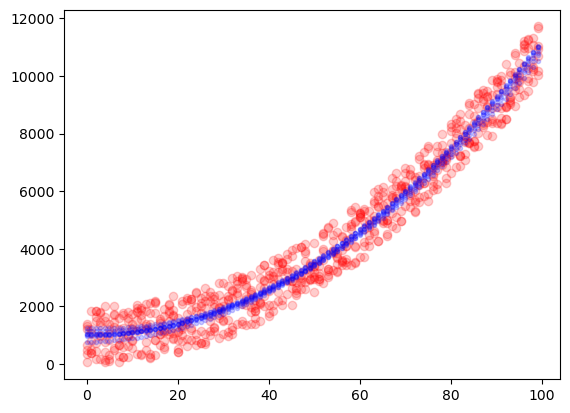

In [32]:
true_function_degree = 2
regressor_degree = 2
num_data_point = 100 # fake observation data point per service
randomize_factor = 2000
x_rps = list()
x_cpu = list()
x_service_name = list()
y_service_time = list()
for svc in sim.dag.all_service:
    x_rps += list(np.arange(0,num_data_point))
    x_cpu += list((np.arange(0,num_data_point))/2)
    x_service_name += [svc.name] * num_data_point
    for i in range(num_data_point):
        y_service_time.append(pow(x_rps[i],true_function_degree) + random.random()*randomize_factor)
        # y_service_time.append(pow(x_rps[i],true_function_degree) + x_cpu[i] + random.random()*randomize_factor)

observation = pd.DataFrame(
    data={
        "service_name": x_service_name,
        "rps": x_rps, 
        "cpu": x_cpu, 
        "service_time": y_service_time,
    },
    # index=x_service_name
)
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(observation)
display(observation)

X = observation[["service_name", "rps", "cpu"]]
# X = observation[["service_name", "rps"]]
y = observation["service_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

feat_transform = make_column_transformer(
    (OneHotEncoder(), ["service_name"]),
    # (StandardScaler(), ["rps", "cpu"]),
    ("passthrough", ["rps", "cpu"]),
    # ("passthrough", ["rps"]),
    verbose_feature_names_out=False
)


## Pipeline consists of
## 1. trasformation of input feature
## 2. training the model using X_train, y_train dataset
if regressor_degree == 1:
    reg = make_pipeline(feat_transform, LinearRegression())
    reg.fit(X_train, y_train)
elif regressor_degree > 1:
    poly = PolynomialFeatures(degree=regressor_degree, include_bias=True)
    reg = make_pipeline(feat_transform, poly, LinearRegression())
    reg.fit(X_train, y_train)
    #################################################
    ## Breaking down polynomial regressor pipeline ##
    #################################################
    # print("Original X_train: ", X_train)
    # X_train_T = feat_transform.fit_transform(X_train)
    # print("X_train_T: ", X_train_T)
    # poly = PolynomialFeatures(degree=regressor_degree, include_bias=True)
    # X_train_poly = poly.fit_transform(X_train_T)
    # print("X_train_poly: ", X_train_poly)
    # reg = LinearRegression()
    # reg.fit(X_train_poly, y_train)
    # print("poly.get_feature_names_out(): ", poly.get_feature_names_out())

## Debug print
# print(reg[0])
# print(reg[1])
# print(reg)

## Print trained parameters(coefficients) of the model
print("Coefficients of linear regression model: ", reg["linearregression"].coef_)

## Run prediction and compare it with the ground truth to see how accurate the trained model is
y_pred = reg.predict(X_test)
print(f"The R^2 value in the test set is {np.round(r2_score(y_test, y_pred),5)}")
plt.plot(X["rps"], y, 'ro', label="observation", alpha=0.2)
plt.plot(X["rps"], reg.predict(X), 'b.', label="observation", alpha=0.2)
plt.show()

## Optimize latency for num of requests

Notation for the formulation of the mathematical optimization model.
The subscript $s$ will be used to denote each region.
### Input parameters
- $ServiceTime(r)$: predicted service time of service $s$ when rps is $r$. (~~asdf$ServiceTime(r, c, m, s)$ cpu util is $c$, memory util is $m$~~.)
- $r^s_{min}$: minimum rps for service $s$
- $r^s_{max}$: maximum rps for service $s$

cpu and mem are **Not** being used
- $c^s_{min}$: minimum cpu util for service $s$
- $c^s_{max}$: maximum cpu util for service $s$
- $m^s_{min}$: minimum memory util for service $s$
- $m^s_{max}$: maximum memory util for service $s$

## Decision Variables
(A decision variable is an unknown in an optimization problem.)

- $num\ request$: inbound number of request to *User*
  
- $rps^{dst}_{src}$: number of request from src to dst

- $service\ time^{dst}_{src}(r)$: **predicted** service time from $src$ to $dst$ in $arcs$ gurobi variable when $rps^{dst}_{src}$ is $r$.

  $rps$ is inbound flow into dst node which is represented by $flow$ variable later.
        
- $network\ latency^{dst}_{src}$: network latency between $src$ and $dst$ in $arcs$ gurobi variable. 
        
  It is fixed value. (It is not determineded yet that it should be RTT or one-way latency.)
  

In [16]:
def trunc(temp): # utility function for node naming
    st = temp.find("(")
    temp = temp[:st]
    return temp

NUM_REQUEST = [100, 100] # [num req into User1 (cluster 1), num req in User2 (cluster 2)]

source = dict()
for repl in sim.dag.all_replica:
    if repl.service.name == "User":
        source[trunc(repl.to_str())] = NUM_REQUEST[repl.cluster_id]
print("source (load):", source)

total_num_request = sum(x for x in NUM_REQUEST)
destination = dict({"dst": total_num_request})
print("destination:", destination)

node = dict()
max_tput = total_num_request
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        node[trunc(repl.to_str())+"_start"] = max_tput
        node[trunc(repl.to_str())+"_end"] = max_tput
print("node: ", node)

arcs = gp.tuplelist() # [(1,2), (1,3), (2,4)]
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        src = trunc(repl.to_str())+"_start"
        dst = trunc(repl.to_str())+"_end"
        arcs.append((src, dst))
        
for parent_repl in sim.dag.child_replica:
    for child_svc in sim.dag.child_replica[parent_repl]:
        child_repl_list = sim.dag.child_replica[parent_repl][child_svc]
        for child_repl in child_repl_list:
            if parent_repl.service.name == "User":
                src = trunc(parent_repl.to_str())
                dst = trunc(child_repl.to_str())+"_start"
                arcs.append((src, dst))
            else:
                src = trunc(parent_repl.to_str())+"_end"
                dst = trunc(child_repl.to_str())+"_start"
                arcs.append((src, dst))
for repl in sim.dag.all_replica:
    if sim.dag.is_leaf(repl.service):
        src = trunc(repl.to_str())+"_end"
        dst = "dst"
        arcs.append((src, dst))

print("\n ========== arcs ========== ")
print(arcs)

source (load): {'User_0': 100, 'User_1': 100}
destination: {'dst': 200}
node:  {'A_0_start': 200, 'A_0_end': 200, 'A_2_start': 200, 'A_2_end': 200, 'B_0_start': 200, 'B_0_end': 200, 'B_2_start': 200, 'B_2_end': 200, 'C_0_start': 200, 'C_0_end': 200, 'C_2_start': 200, 'C_2_end': 200, 'D_0_start': 200, 'D_0_end': 200, 'D_2_start': 200, 'D_2_end': 200, 'E_0_start': 200, 'E_0_end': 200, 'E_2_start': 200, 'E_2_end': 200, 'F_0_start': 200, 'F_0_end': 200, 'F_2_start': 200, 'F_2_end': 200, 'A_1_start': 200, 'A_1_end': 200, 'A_3_start': 200, 'A_3_end': 200, 'B_1_start': 200, 'B_1_end': 200, 'B_3_start': 200, 'B_3_end': 200, 'C_1_start': 200, 'C_1_end': 200, 'C_3_start': 200, 'C_3_end': 200, 'D_1_start': 200, 'D_1_end': 200, 'D_3_start': 200, 'D_3_end': 200, 'E_1_start': 200, 'E_1_end': 200, 'E_3_start': 200, 'E_3_end': 200, 'F_1_start': 200, 'F_1_end': 200, 'F_3_start': 200, 'F_3_end': 200}

 ========== arcs ========== 
<gurobi.tuplelist (128 tuples, 2 values each):
 ( A_0_start , A_0_end   )


In [36]:
service_name_list = list()
for svc in sim.dag.all_service:
    service_name_list.append(svc.name)
    
min_cpu = 0
max_cpu = 100
# min_mem = 0
# max_mem = 100
min_rps = 0
max_rps = GRB.INFINITY
min_service_time = [0] * len(service_name_list)
max_service_time = [GRB.INFINITY] * len(service_name_list) # SLO
min_network_latency = [0] * len(service_name_list)
max_network_latency = [GRB.INFINITY] * len(service_name_list)

data = pd.DataFrame(
    data={
        "service_name":service_name_list,
        "min_cpu":[min_cpu]*len(service_name_list),
        "max_cpu":[max_cpu]*len(service_name_list),
        # "min_mem":[min_mem]*len(service_name_list),
        # "max_mem":[max_mem]*len(service_name_list),
        # "min_rps":[max_mem]*len(service_name_list),
        "min_rps":[min_rps]*len(service_name_list),
        "max_rps":[max_rps]*len(service_name_list),
        "min_service_time": min_service_time,
        "max_service_time": max_service_time,
        "min_network_latency": min_network_latency,
        "max_network_latency": max_network_latency,
    },
    index=service_name_list
)
data

,service_name,min_cpu,max_cpu,min_rps,max_rps,min_service_time,max_service_time,min_network_latency,max_network_latency
User,User,0,100,0,1.000000e+100,0,1.000000e+100,0,1.000000e+100
A,A,0,100,0,1.000000e+100,0,1.000000e+100,0,1.000000e+100
B,B,0,100,0,1.000000e+100,0,1.000000e+100,0,1.000000e+100
C,C,0,100,0,1.000000e+100,0,1.000000e+100,0,1.000000e+100
D,D,0,100,0,1.000000e+100,0,1.000000e+100,0,1.000000e+100
E,E,0,100,0,1.000000e+100,0,1.000000e+100,0,1.000000e+100
F,F,0,100,0,1.000000e+100,0,1.000000e+100,0,1.000000e+100


In [37]:
model = gp.Model('RequestRouting')

# Add variables for the regression
service_time = gppd.add_vars(model, data, name="service_time", lb="min_service_time", ub="max_service_time") # Y
rps = gppd.add_vars(model, data, name="rps", lb="min_rps", ub="max_rps") # X
cpu = gppd.add_vars(model, data, name="cpu", lb="min_cpu", ub="max_cpu") # X
# mem = gppd.add_vars(model, data, lb=-gp.GRB.INFINITY, name="mem") # X
network_latency = gppd.add_vars(model, data, name="network_latency", lb="min_network_latency", ub="max_network_latency") # Y
model.update()

# print("="*30 + " var: rps " + "="*30)
# print(rps)
# print("="*30 + " var: service time " + "="*30)
# print(service_time)
# print("="*30 + " var: network latency " + "="*30)
# print(network_latency)
# print("="*30 + " model object " + "="*30)
# print(model)

In [19]:
X_train

,service_name,rps
306,C,6
585,E,85
107,A,7
17,User,17
609,F,9
...,...,...
144,A,44
645,F,45
72,User,72
235,B,35


In [38]:
m_feats = pd.DataFrame(
    data={
        "service_name": service_name_list,
        "rps": rps,
        "cpu": cpu,
    },
    index=service_name_list
)

m_feats

,service_name,rps,cpu
User,User,<gurobi.Var rps[User]>,<gurobi.Var cpu[User]>
A,A,<gurobi.Var rps[A]>,<gurobi.Var cpu[A]>
B,B,<gurobi.Var rps[B]>,<gurobi.Var cpu[B]>
C,C,<gurobi.Var rps[C]>,<gurobi.Var cpu[C]>
D,D,<gurobi.Var rps[D]>,<gurobi.Var cpu[D]>
E,E,<gurobi.Var rps[E]>,<gurobi.Var cpu[E]>
F,F,<gurobi.Var rps[F]>,<gurobi.Var cpu[F]>


In [39]:
service_time

User    <gurobi.Var service_time[User]>
A          <gurobi.Var service_time[A]>
B          <gurobi.Var service_time[B]>
C          <gurobi.Var service_time[C]>
D          <gurobi.Var service_time[D]>
E          <gurobi.Var service_time[E]>
F          <gurobi.Var service_time[F]>
Name: service_time, dtype: object

In [40]:
pred_constr = add_predictor_constr(model, reg, m_feats, service_time)
pred_constr.print_stats()
model.update()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Model for pipe:
434 variables
7 constraints
385 quadratic constraints
Input has shape (7, 3)
Output has shape (7, 1)

Pipeline has 3 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans             (7, 9)            0            0            0            0

poly_feat            (7, 55)          434            0          385            0

lin_reg               (7, 1)            0            7            0            0

--------------------------------------------------------------------------------


In [239]:
multi_dict_ = dict()
## Processing time
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        multi_dict_[(trunc(repl.to_str())+"_start", trunc(repl.to_str())+"_end")] = repl.service.processing_time
    
## Network latency
for parent_repl in sim.dag.child_replica:
    for child_svc in sim.dag.child_replica[parent_repl]:
        child_repl_list = sim.dag.child_replica[parent_repl][child_svc]
        for child_repl in child_repl_list:
            if parent_repl.service.name == "User":
                multi_dict_[(trunc(parent_repl.to_str()), trunc(child_repl.to_str())+"_start")] = sim.NetworkLatency().get_latency(parent_repl, child_repl)*2
            else:
                multi_dict_[(trunc(parent_repl.to_str())+"_end", trunc(child_repl.to_str())+"_start")] = sim.NetworkLatency().get_latency(parent_repl, child_repl)*2
                
for repl in sim.dag.all_replica:
    if sim.dag.is_leaf(repl.service):
        multi_dict_[(trunc(repl.to_str())+"_end", "dst")] = 0.0

In [ ]:
# flow = model.addVars(arcs, name="flow")
flow = model.addVars(arcs, obj=latency, name="flow")
model.setObjective(latency, gp.GRB.MINIMIZE)

In [167]:
print("type(flow):", type(flow))
print("flow:", flow)
print()
## debug purpose
# test_node = "B_1_start"
# print("flow.sum(\'*\', test_node):", flow.sum('*', test_node))
# print("flow.select(\'*\', test_node:", flow.select('*', test_node))
# print("arcs.select(\'*\', test_node):", arcs.select('*', test_node))

# Constraint 1: source
src_keys = source.keys()
src_flow = model.addConstrs((gp.quicksum(flow.select(src, '*')) == source[src] for src in src_keys), name="source")

# Constraint 2: destination
dest_keys = destination.keys()
num_leaf_svc = 0
leaf_svc = list()
for svc in sim.dag.all_service:
    # print("iterate ", svc.name)
    if sim.dag.is_leaf(svc):
        num_leaf_svc += 1
        leaf_svc.append(svc.name)
print("leaf_svc: ", leaf_svc)
print("num_leaf_svc: ", num_leaf_svc)
dst_flow = model.addConstrs((gp.quicksum(flow.select('*', dst)) == destination[dst]*num_leaf_svc for dst in dest_keys), name="destination")

# Constraint 3: flow conservation
# node_key = node.keys()
# node_flow = model.addConstrs((gp.quicksum(flow.select('*', n_)) == gp.quicksum(flow.select(n_, '*')) for n_ in node_key), name="flow_conservation")
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        # Start node in-out flow conservation
        st = trunc(repl.to_str())+"_start"
        node_flow = model.addConstr((gp.quicksum(flow.select('*', st)) == gp.quicksum(flow.select(st, '*'))), name="flow_conservation["+st+"]")
        # End node in-out flow conservation
        en = trunc(repl.to_str())+"_end"
        if sim.dag.is_leaf(repl.service):
            node_flow = model.addConstr((gp.quicksum(flow.select('*', en)) == gp.quicksum(flow.select(en, '*'))), name="flow_conservation["+en+"]")
        else:
            for child_svc in repl.child_services:
                out_sum = 0
                for child_repl in child_svc.replicas:
                    child_repl_name = trunc(child_repl.to_str()) + "_start"
                    out_sum += flow.sum(en, child_repl_name)
                node_flow = model.addConstr((gp.quicksum(flow.select('*', en)) == out_sum), name="flow_conservation["+en+"]")

# Constraint 4: Tree topology
for svc in sim.dag.all_service:
    if svc.name != "User":
        svc_repl = svc.replicas
        sum_ = 0
        for repl in svc_repl:
            repl_name = trunc(repl.to_str()) + "_start"
            sum_ += flow.sum('*', repl_name)
        #     print("repl_name:", repl_name)
        #     print("flow.sum('*', repl_name):", flow.sum('*', repl_name))
        # print("flow sum ({}): {}".format(svc.name, sum_))
        node_flow = model.addConstr(sum_ == total_num_request, name="tree_topo_conservation")
        # print()

# Constraint 5: max throughput of service
node_key = node.keys()
throughput = model.addConstrs((gp.quicksum(flow.select('*', n_)) <= node[n_] for n_ in node_key), name="service_capacity")

type(flow): <class 'gurobipy.tupledict'>
flow: {('A_0_start', 'A_0_end'): <gurobi.Var *Awaiting Model Update*>, ('A_2_start', 'A_2_end'): <gurobi.Var *Awaiting Model Update*>, ('B_0_start', 'B_0_end'): <gurobi.Var *Awaiting Model Update*>, ('B_2_start', 'B_2_end'): <gurobi.Var *Awaiting Model Update*>, ('C_0_start', 'C_0_end'): <gurobi.Var *Awaiting Model Update*>, ('C_2_start', 'C_2_end'): <gurobi.Var *Awaiting Model Update*>, ('D_0_start', 'D_0_end'): <gurobi.Var *Awaiting Model Update*>, ('D_2_start', 'D_2_end'): <gurobi.Var *Awaiting Model Update*>, ('E_0_start', 'E_0_end'): <gurobi.Var *Awaiting Model Update*>, ('E_2_start', 'E_2_end'): <gurobi.Var *Awaiting Model Update*>, ('F_0_start', 'F_0_end'): <gurobi.Var *Awaiting Model Update*>, ('F_2_start', 'F_2_end'): <gurobi.Var *Awaiting Model Update*>, ('A_1_start', 'A_1_end'): <gurobi.Var *Awaiting Model Update*>, ('A_3_start', 'A_3_end'): <gurobi.Var *Awaiting Model Update*>, ('B_1_start', 'B_1_end'): <gurobi.Var *Awaiting Model Up

In [166]:
print(model.getObjective())

0.0


In [12]:
##############################################################################
model.optimize()

# Variable info
varInfo = [(v.varName, v.LB, v.UB) for v in model.getVars() ] # use list comprehension
df_var = pd.DataFrame(varInfo) # convert to pandas dataframe
df_var.columns=['Variable Name','LB','UB'] # Add column headers
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_var)

# Linear constraint info
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_constr)
display(df_constr)
        
        
if model.Status == GRB.INFEASIBLE:
    print("###########################")
    print("#### INFEASIBLE MODEL! ####")
    print("###########################")
    model.computeIIS()
    model.write("model.ilp")
    print('\nThe following constraints and variables are in the IIS:')
    # for c in model.getConstrs():
    #     if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')
    for v in model.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
else:
    request_flow = pd.DataFrame(columns=["From", "To", "Flow"])
    for arc in arcs:
        if flow[arc].x > 1e-6:
            temp = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [flow[arc].x]})
            request_flow = pd.concat([request_flow, temp], ignore_index=True)
    display(request_flow)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 117 rows, 128 columns and 468 nonzeros
Model fingerprint: 0x5fad0a50
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 8e+02]
Presolve removed 47 rows and 16 columns
Presolve time: 0.00s
Presolved: 70 rows, 112 columns, 323 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0000000e+02   7.500000e+01   0.000000e+00      0s
      42    3.0200000e+04   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.020000000e+04


,Constraint Name,Constraint equation,Sense,RHS
0,source[User_0],"flow[User_0,A_0_start] + flow[User_0,A_2_start...",=,100.0
1,source[User_1],"flow[User_1,A_0_start] + flow[User_1,A_2_start...",=,100.0
2,destination[dst],"flow[B_0_end,dst] + flow[B_2_end,dst] + flow[C...",=,800.0
3,flow_conservation[A_0_start],"-1.0 flow[A_0_start,A_0_end] + flow[User_0,A_0...",=,0.0
4,flow_conservation[A_0_end],"flow[A_0_start,A_0_end] + -1.0 flow[A_0_end,B_...",=,0.0
...,...,...,...,...
112,service_capacity[E_3_end],"flow[E_3_start,E_3_end]",<,200.0
113,service_capacity[F_1_start],"flow[D_0_end,F_1_start] + flow[D_2_end,F_1_sta...",<,200.0
114,service_capacity[F_1_end],"flow[F_1_start,F_1_end]",<,200.0
115,service_capacity[F_3_start],"flow[D_0_end,F_3_start] + flow[D_2_end,F_3_sta...",<,200.0


,From,To,Flow
0,A_2_start,A_2_end,100.0
1,B_2_start,B_2_end,100.0
2,C_2_start,C_2_end,100.0
3,D_2_start,D_2_end,100.0
4,E_2_start,E_2_end,100.0
5,F_0_start,F_0_end,100.0
6,A_3_start,A_3_end,100.0
7,B_3_start,B_3_end,100.0
8,C_1_start,C_1_end,100.0
9,D_3_start,D_3_end,100.0


In [13]:
print(model.objVal)

30200.0


In [13]:
new_table = pd.DataFrame(columns=[] )
new_table

,From,To,Flow
0,A_2_start,A_2_end,100.0
1,B_2_start,B_2_end,100.0
2,C_2_start,C_2_end,100.0
3,D_2_start,D_2_end,100.0
4,E_2_start,E_2_end,100.0
5,F_0_start,F_0_end,100.0
6,A_3_start,A_3_end,100.0
7,B_3_start,B_3_end,100.0
8,C_1_start,C_1_end,100.0
9,D_3_start,D_3_end,100.0


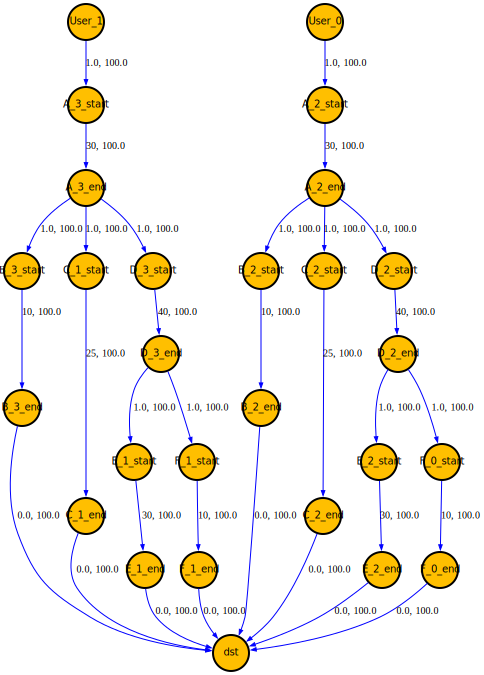

In [103]:
g_ = graphviz.Digraph()
# The node() method takes a name identifier as first argument and an optional label.
# The edge() method takes the names of start node and end node
# g_.size ="3,3"
print_all = True
node_pw = "2"
edge_pw = "1"
fs = "10"
edge_fs_0 = "10"
edge_fs_1 = "5"
fn="times bold italic"
edge_arrowsize="0.5"
edge_minlen="1"

if print_all:
    for k, v in latency.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
            g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
            g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            g_.edge(k[0], k[1], label=str(v)+", "+str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
else:
    for k, v in latency.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
        else:
            node_color = "#A7A4A4"
        g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.75")
        g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            g_.edge(k[0], k[1], label=str(v)+", "+str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
        else:
            g_.edge(k[0], k[1], label=str(v), penwidth=edge_pw, style="dotted", fontsize=edge_fs_1, arrowhead="none", minlen=edge_minlen)
g_